In [1]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
import keras
import optuna

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from path import Path

In [2]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_id = test['PassengerId']

## Analyze the Data

可以看到cabin的na很多，ticket的意义不大，这两个feature直接丢掉。

In [12]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
data.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

In [15]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


name 里面有个title和家族名值得提取，可能会有有用的信息。

In [16]:
data['Titles'] = [re.search(r'\b([A-Za-z]+)\.', name)[0] for name in data['Name']]
data['Family'] = [re.search(r'\b([A-Za-z]+)\,', name)[0] for name in data['Name']]

In [17]:
#data.drop(['Name'], axis=1, inplace=True)
data.drop(['Family', 'Name'], axis=1, inplace=True)

In [18]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3,17
top,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr.
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,NaN,644,517
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN


我们的特征已经处理好了，里面还有些缺失值，先不管
编码一下字符特征

In [3]:
from sklearn.preprocessing import LabelEncoder, minmax_scale

le = LabelEncoder()

In [ ]:
for str_feature in ['Titles', 'Sex', 'Embarked']:
    data[str_feature] = le.fit_transform(data[str_feature])

In [20]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles
0,1,0,3,1,22.0,1,0,7.2500,2,12
1,2,1,1,0,38.0,1,0,71.2833,0,13
2,3,1,3,0,26.0,0,0,7.9250,2,9
3,4,1,1,0,35.0,1,0,53.1000,2,13
4,5,0,3,1,35.0,0,0,8.0500,2,12


In [3]:
from sklearn.preprocessing import LabelEncoder, minmax_scale

le = LabelEncoder()

def data_preprocessing(data):
    data.drop(['Ticket', 'Cabin'], axis=1, inplace=True)
    data['Titles'] = [re.search(r'\b([A-Za-z]+)\.', name)[0] for name in data['Name']]
    data.drop(['Name'], axis=1, inplace=True)
    
    for str_feature in ['Titles', 'Sex', 'Embarked']:
        data[str_feature] = le.fit_transform(data[str_feature])
        
    data.drop(['PassengerId', 'Titles'], axis=1, inplace=True)
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Age'] = minmax_scale(data['Age'])
    data['Fare'] = minmax_scale(data['Fare'])
    
    return data

# Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_id = test['PassengerId']

test = data_preprocessing(test)
train = data_preprocessing(train)

x = train.drop('Survived', axis=1)
y = train['Survived']

# Model Training

## LGBM

In [92]:
class LGBConfig:
    input_path = Path('data')
    optuna_lgb = True
    n_estimators = 1500
    early_stopping_round = 100
    cv_folds = 5
    random_state = 55
    n_trials = 100
    params = {'objective': 'binary',
              'boosting_type': 'gbdt',
              'learning_rate': 0.2,
              'num_leaves': 200,
              'min_child_samples': 5,
              'colsample_bytree': 0.3,
              'subsample_freq': 4,
              'subsample': 0.4,
              'reg_alpha': 0.0,
              'reg_lambda': 0.05,
              'verbosity': 0,
              'random_state': 0}
    
lgb_config = LGBConfig()

In [93]:
# wrap the metric for lgb
def roc_auc_lgb(y_true, y_pred):
    eval_name = 'roc_auc'
    eval_result = roc_auc_score(y_true, y_pred)
    is_higher_better = True
    return eval_name, eval_result, is_higher_better

def accuracy_lgb(y_true, y_pred):
    eval_name = 'accuracy'
    eval_result = accuracy_score(y_true, [1 if i >0.5 else 0  for i in y_pred])
    is_higher_better = True
    return eval_name, eval_result, is_higher_better

In [94]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
 
if lgb_config.optuna_lgb:
        
    def objective(trial):
        params = {
                'learning_rate': trial.suggest_float("learning_rate", 0.01, 1.0),
                'num_leaves': trial.suggest_int("num_leaves", 3, 255),
                'max_bin':trial.suggest_int("max_bin", 3, 50),
                'min_child_samples': trial.suggest_int("min_child_samples", 3, 200),
                'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
                'subsample_freq': trial.suggest_int("subsample_freq", 0, 10),
                'subsample': trial.suggest_float("subsample", 0.1, 1.0),
                'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-9, 10.0),
                'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-9, 10.0),
        }
        
        score = []
        skf = StratifiedKFold(n_splits=lgb_config.cv_folds, shuffle=True, random_state=lgb_config.random_state)
        kf = KFold(n_splits=lgb_config.cv_folds, shuffle=True, random_state=lgb_config.random_state)

        for train_idx, valid_idx in skf.split(x, y):
            x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
            x_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]

            model = lgb.LGBMClassifier(**params,
                                    n_estimators=lgb_config.n_estimators,
                                    early_stopping_round=lgb_config.early_stopping_round)

            callbacks=[lgb.early_stopping(stopping_rounds=lgb_config.early_stopping_round, verbose=False)]
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric=accuracy_lgb, callbacks=callbacks)
            score.append(model.best_score_['valid_0']['accuracy'])
        return np.mean(score) - 5 * np.std(score)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=lgb_config.n_trials, show_progress_bar=True)

    print("Best Score", study.best_value)
    print("Best parameters", study.best_params)
    
    params = {'objective': 'binary',
            'boosting_type': 'gbdt',
            'verbosity': 0,
            'random_state': lgb_config.random_state}
    
    params.update(study.best_params)
else:
    params = lgb_config.params

[I 2023-12-06 14:31:16,879] A new study created in memory with name: no-name-7b92b28a-7e3e-4151-a3ed-dc5721b9eaa1


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-06 14:31:18,493] Trial 0 finished with value: 0.6519758795452837 and parameters: {'learning_rate': 0.34654775227086365, 'num_leaves': 241, 'max_bin': 26, 'min_child_samples': 135, 'colsample_bytree': 0.7040554363126199, 'subsample_freq': 6, 'subsample': 0.7364434901968714, 'reg_alpha': 1.6391376570292808e-09, 'reg_lambda': 9.191447465634198e-05}. Best is trial 0 with value: 0.6519758795452837.
[I 2023-12-06 14:31:20,058] Trial 1 finished with value: 0.573950048367815 and parameters: {'learning_rate': 0.8802310206709125, 'num_leaves': 194, 'max_bin': 15, 'min_child_samples': 95, 'colsample_bytree': 0.5519608212900636, 'subsample_freq': 8, 'subsample': 0.48254675557873383, 'reg_alpha': 4.4085040093555214, 'reg_lambda': 8.264814659852402e-09}. Best is trial 0 with value: 0.6519758795452837.
[I 2023-12-06 14:31:21,329] Trial 2 finished with value: 0.6447133199113428 and parameters: {'learning_rate': 0.27480116209130745, 'num_leaves': 7, 'max_bin': 18, 'min_child_samples': 110, '

In [110]:
preds = np.zeros(len(test))
oof = np.zeros(len(train)) # oof 是模型对每一个val预测加总，加起来就是对整个set的预测。
metric_evaluations = []

skf = StratifiedKFold(n_splits=lgb_config.cv_folds, shuffle=True, random_state=lgb_config.random_state)
kf = KFold(n_splits=lgb_config.cv_folds, shuffle=True, random_state=lgb_config.random_state)

for idx, (train_idx, valid_idx) in enumerate(skf.split(x, y)):
    print(f"CV fold {idx}")
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]
    
    model = lgb.LGBMClassifier(**params,
                               n_estimators=lgb_config.n_estimators,
                               early_stopping_round=lgb_config.early_stopping_round,
                               force_row_wise=True)
    
    callbacks=[lgb.early_stopping(stopping_rounds=lgb_config.early_stopping_round), 
               lgb.log_evaluation(period=100, show_stdv=False)]
                                                                                           
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric=accuracy_lgb, callbacks=callbacks)
    metric_evaluations.append(model.best_score_['valid_0']['accuracy'])
    preds += model.predict_proba(test, num_iteration=model.best_iteration_)[:,1] / kf.n_splits
    oof[valid_idx] = model.predict_proba(x_valid, num_iteration=model.best_iteration_)[:,1]

CV fold 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [111]:
print(f"LightGBM Score: {np.mean(metric_evaluations):0.3f} ({np.std(metric_evaluations):0.3f})")

LightGBM Score: 0.836 (0.015)


In [112]:
metric_evaluations

[0.8547486033519553,
 0.8426966292134831,
 0.8370786516853933,
 0.8370786516853933,
 0.8089887640449438]

In [101]:
# 输出预测
submission = pd.read_csv('data/gender_submission.csv')
submission['Survived'] = np.where(preds>0.50,1,0)
submission.to_csv('lgb_submission.csv', index=False)

<Axes: ylabel='Proportion'>

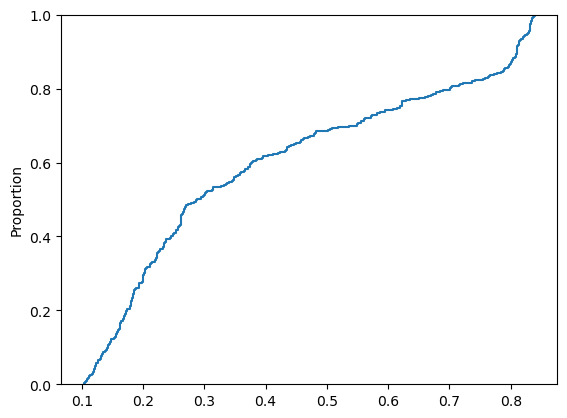

In [102]:
sns.ecdfplot(preds)

In [129]:
oofs = y.to_frame()
oofs['target'] = oof

## NN

In [272]:
import tensorflow as tf
import keras


seed = 42
keras.utils.set_random_seed(seed)
keras.backend.backend(), keras.__version__

('tensorflow', '3.0.0')

In [113]:
input_dim = x.shape[1]

nn_clf = keras.Sequential(
    [
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(12, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(6, activation='relu'),
        #keras.layers.Dropout(0.2),
        #keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

nn_clf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)                │         96 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 12)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 6)                 │         78 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │          7 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

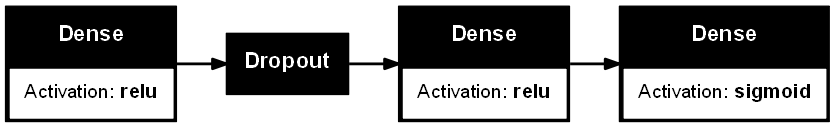

In [114]:
keras.utils.plot_model(nn_clf, show_layer_activations=True, dpi=100, rankdir="LR")

In [115]:
optimzer = keras.optimizers.Adam(learning_rate=0.002)

nn_clf.compile(
    optimizer = optimzer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)

In [116]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=20,verbose=1, restore_best_weights=True),
]

history = nn_clf.fit(x=x_train, y=y_train, epochs=500, verbose=2, 
                     validation_split=0.15,
                     shuffle=True,
                     callbacks=my_callbacks)

Epoch 1/500
19/19 - 4s - 186ms/step - accuracy: 0.5561 - loss: 0.6686 - val_accuracy: 0.6449 - val_loss: 0.6401
Epoch 2/500
19/19 - 0s - 5ms/step - accuracy: 0.6073 - loss: 0.6611 - val_accuracy: 0.6636 - val_loss: 0.6133
Epoch 3/500
19/19 - 0s - 6ms/step - accuracy: 0.6172 - loss: 0.6416 - val_accuracy: 0.6636 - val_loss: 0.6023
Epoch 4/500
19/19 - 0s - 6ms/step - accuracy: 0.6188 - loss: 0.6440 - val_accuracy: 0.6729 - val_loss: 0.5931
Epoch 5/500
19/19 - 0s - 5ms/step - accuracy: 0.6287 - loss: 0.6329 - val_accuracy: 0.6822 - val_loss: 0.5834
Epoch 6/500
19/19 - 0s - 5ms/step - accuracy: 0.6337 - loss: 0.6230 - val_accuracy: 0.7009 - val_loss: 0.5763
Epoch 7/500
19/19 - 0s - 6ms/step - accuracy: 0.6403 - loss: 0.6258 - val_accuracy: 0.7290 - val_loss: 0.5674
Epoch 8/500
19/19 - 0s - 5ms/step - accuracy: 0.6386 - loss: 0.6170 - val_accuracy: 0.7383 - val_loss: 0.5552
Epoch 9/500
19/19 - 0s - 6ms/step - accuracy: 0.6766 - loss: 0.6003 - val_accuracy: 0.7383 - val_loss: 0.5430
Epoch 10

<Axes: xlabel='epochs', ylabel='loss'>

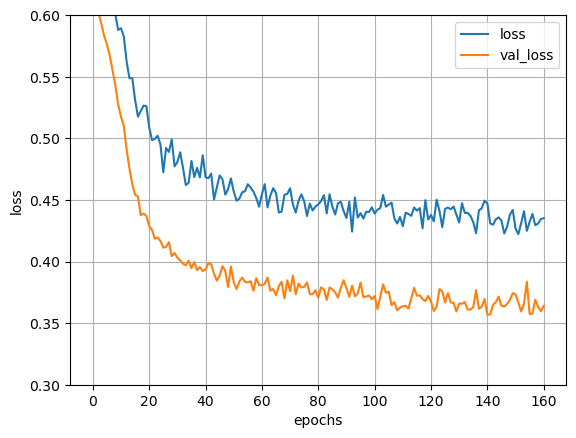

In [117]:
train_log = pd.DataFrame(history.history)
train_log[['loss', 'val_loss']].plot(
    xlabel='epochs',
    ylabel='loss',
    ylim=(0.3,0.6),
    grid=True
)

In [157]:
# 保存一下模型
# nn_clf.save('nn_model4.h5')
# nn_clf = keras.saving.load_model('titanic_0.78947.h5')

In [118]:
y_pred = nn_clf.predict(x)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [121]:
proba_gamma = 0.5
accuracy_score(y, y_pred>proba_gamma)

0.8114478114478114

In [122]:
roc_auc_score(y, y_pred>0.5)

0.7852554884478957

<Axes: ylabel='Proportion'>

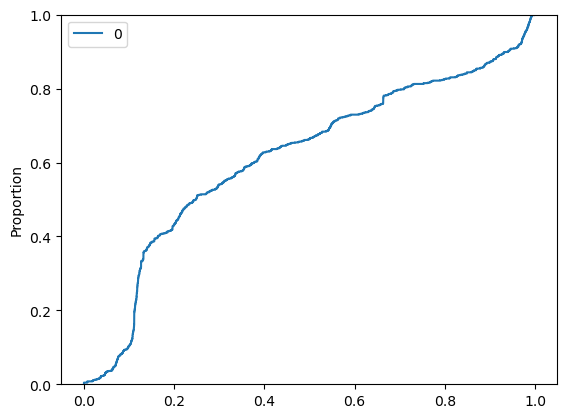

In [247]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.ecdfplot(y_pred)

In [248]:
result = nn_clf.predict(test).flatten()
result = np.where(result>proba_gamma, 1, 0)
result = pd.DataFrame(result, columns=['Survived'])
result['PassengerID'] = test_id
result.to_csv('result.csv', index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


# Ensemble

In [93]:
lgbm_pred = lgbm_clf.predict_proba(test)[:,1]
nn_pred = nn_clf.predict(test).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [94]:
ensemble_pred = np.where((lgbm_pred + nn_pred) > 0.9, 1, 0)

In [95]:
accuracy_score(y_test, ensemble_pred)

ValueError: Found input variables with inconsistent numbers of samples: [179, 418]

In [96]:
result = pd.DataFrame(ensemble_pred, columns=['Survived'])
result['PassengerID'] = test_id
result.to_csv('ensemble_result.csv', index=False)

# OUTPUT

In [315]:
test_result = test.copy()
test_result['Survived'] = lgbm_clf.predict(test)
test_result = test_result[['PassengerId', 'Survived']]
test_result.to_csv('test_result.csv', index=False)